# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 2: Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">


In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Restart the kernel and run the whole notebook again before you submit. 
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed.

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error # imported mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

## <div class="theme">  <b>Predicting Taxi Pickups in NYC</b> </div>

In this homework, we will explore k-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

### <div class="exercise"> <b> Question 1  [20 pts]</b> </div>

**1.1**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 42 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is dependent on the time of the day.  Be sure to title your plot.

**1.3**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly surmise why this may be the case.  This will not be graded harshly, we just want you to think and communicate about the cause.


### Answers

**1.1 Use pandas to load the dataset from the csv file ...**

In [3]:
# read in the file and present the first 10 rows to understand what the data looks like
df_nyc_taxi = pd.read_csv('data/nyc_taxi.csv')
display(df_nyc_taxi.head(10))

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0
5,639.0,37.0
6,819.0,28.0
7,883.0,35.0
8,690.0,27.0
9,68.0,95.0


In [4]:
# split the data with a native splitting method from sklearn
train_data, test_data = train_test_split(df_nyc_taxi, test_size = 0.2, random_state = 42)
print(train_data.TimeMin.head(10))
train_data.TimeMin.shape

1194     404.0
911      131.0
422       85.0
670      539.0
931     1266.0
970     1242.0
1033      21.0
1069    1142.0
1191     589.0
553       81.0
Name: TimeMin, dtype: float64


(1000,)

**1.2 Generate a scatter plot of the training data points**


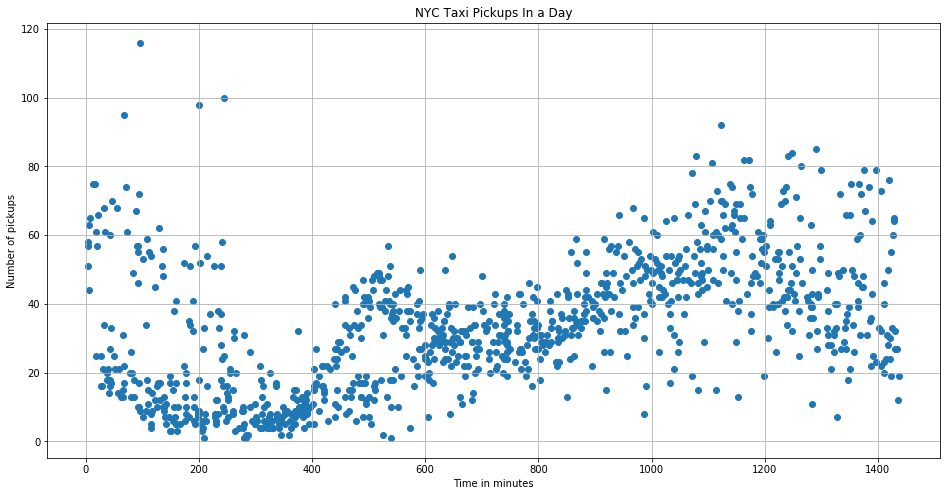

In [5]:
# scatter plot of training data points
x_train_taxi = train_data.TimeMin
y_train_taxi = train_data.PickupCount
plt.figure(figsize=(16,8))
plt.scatter(x_train_taxi, y_train_taxi);
plt.xlabel('Time in minutes')
plt.ylabel('Number of pickups')
plt.title('NYC Taxi Pickups In a Day')
plt.grid(True)

**1.3 In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**

The number of taxi pickups fluctuates throughout the day (perhaps in a sinusoidal pattern, despite some outliers). Taxis pick up the largest number of rides at around 6 PM, which could be attributed to travel logistics associated with dinner plans and the end of the work day. The fewest number of pickups happens at around 4 am, when most people are asleep or do not require taxis. There is also a high number of rides around midnight but there are also many high outliers in this time (around 100-200 minutes from midnight) which may be due to sporadic events (e.g., concerts, sports games, etc.). 

**1.4 You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes...**

The hole shows that some drivers are completing few rides while others are completing a much higher number of rides than would be expected for this sinusoid. It is possible that some drivers are taking a break and as a result, these drivers take in fewer pickups (about 20-30 rides) than those who are not taking a break. Those who are not breaking may be picking up higher numbers (closer to 50-60 rides) to accomodate for the lack of taxi drivers on the road. This break may be due to a shift change. It is also possible that this break is due to heavy traffic during the morning commute and some drivers that work in these regions are not able to take as many rides as the drivers that work in other areas without the traffic.

<hr>

### <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen k-Nearest Neighbors (k-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run k-NN Regression. 


**2.1**. Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4**. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).

### Answers

**2.1 Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary...** 

In [6]:
# reformatting data for use in sklearn

# x train
x_train_taxi = (np.array(x_train_taxi)).reshape(np.array(x_train_taxi).shape[0], 1)

# y train
y_train_taxi = train_data[['PickupCount']]

# formatting for later
x_test_taxi = np.array(test_data.TimeMin)
x_test_taxi = pd.DataFrame(x_test_taxi)
y_test_taxi = test_data.PickupCount

KNNmodels = {}

# creating a list of k values for the nearest neighbor calculations
k_list = [1, 10, 75, 250, 500, 750, 1000]

for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(x_train_taxi, y_train_taxi)
    # store values in a dictionary
    KNNmodels[k] = knnreg
KNNmodels

{1: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'),
 10: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform'),
 75: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=75, p=2,
                     weights='uniform'),
 250: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform'),
 500: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=500, p=2,
                     weights='uniform'),
 750: KNeighborsRegressor(algorit

**2.2  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set...**

In [7]:
print(train_data.head(10))

      TimeMin  PickupCount
1194    404.0          5.0
911     131.0         17.0
422      85.0         13.0
670     539.0         36.0
931    1266.0         46.0
970    1242.0         83.0
1033     21.0         57.0
1069   1142.0         74.0
1191    589.0         27.0
553      81.0         13.0


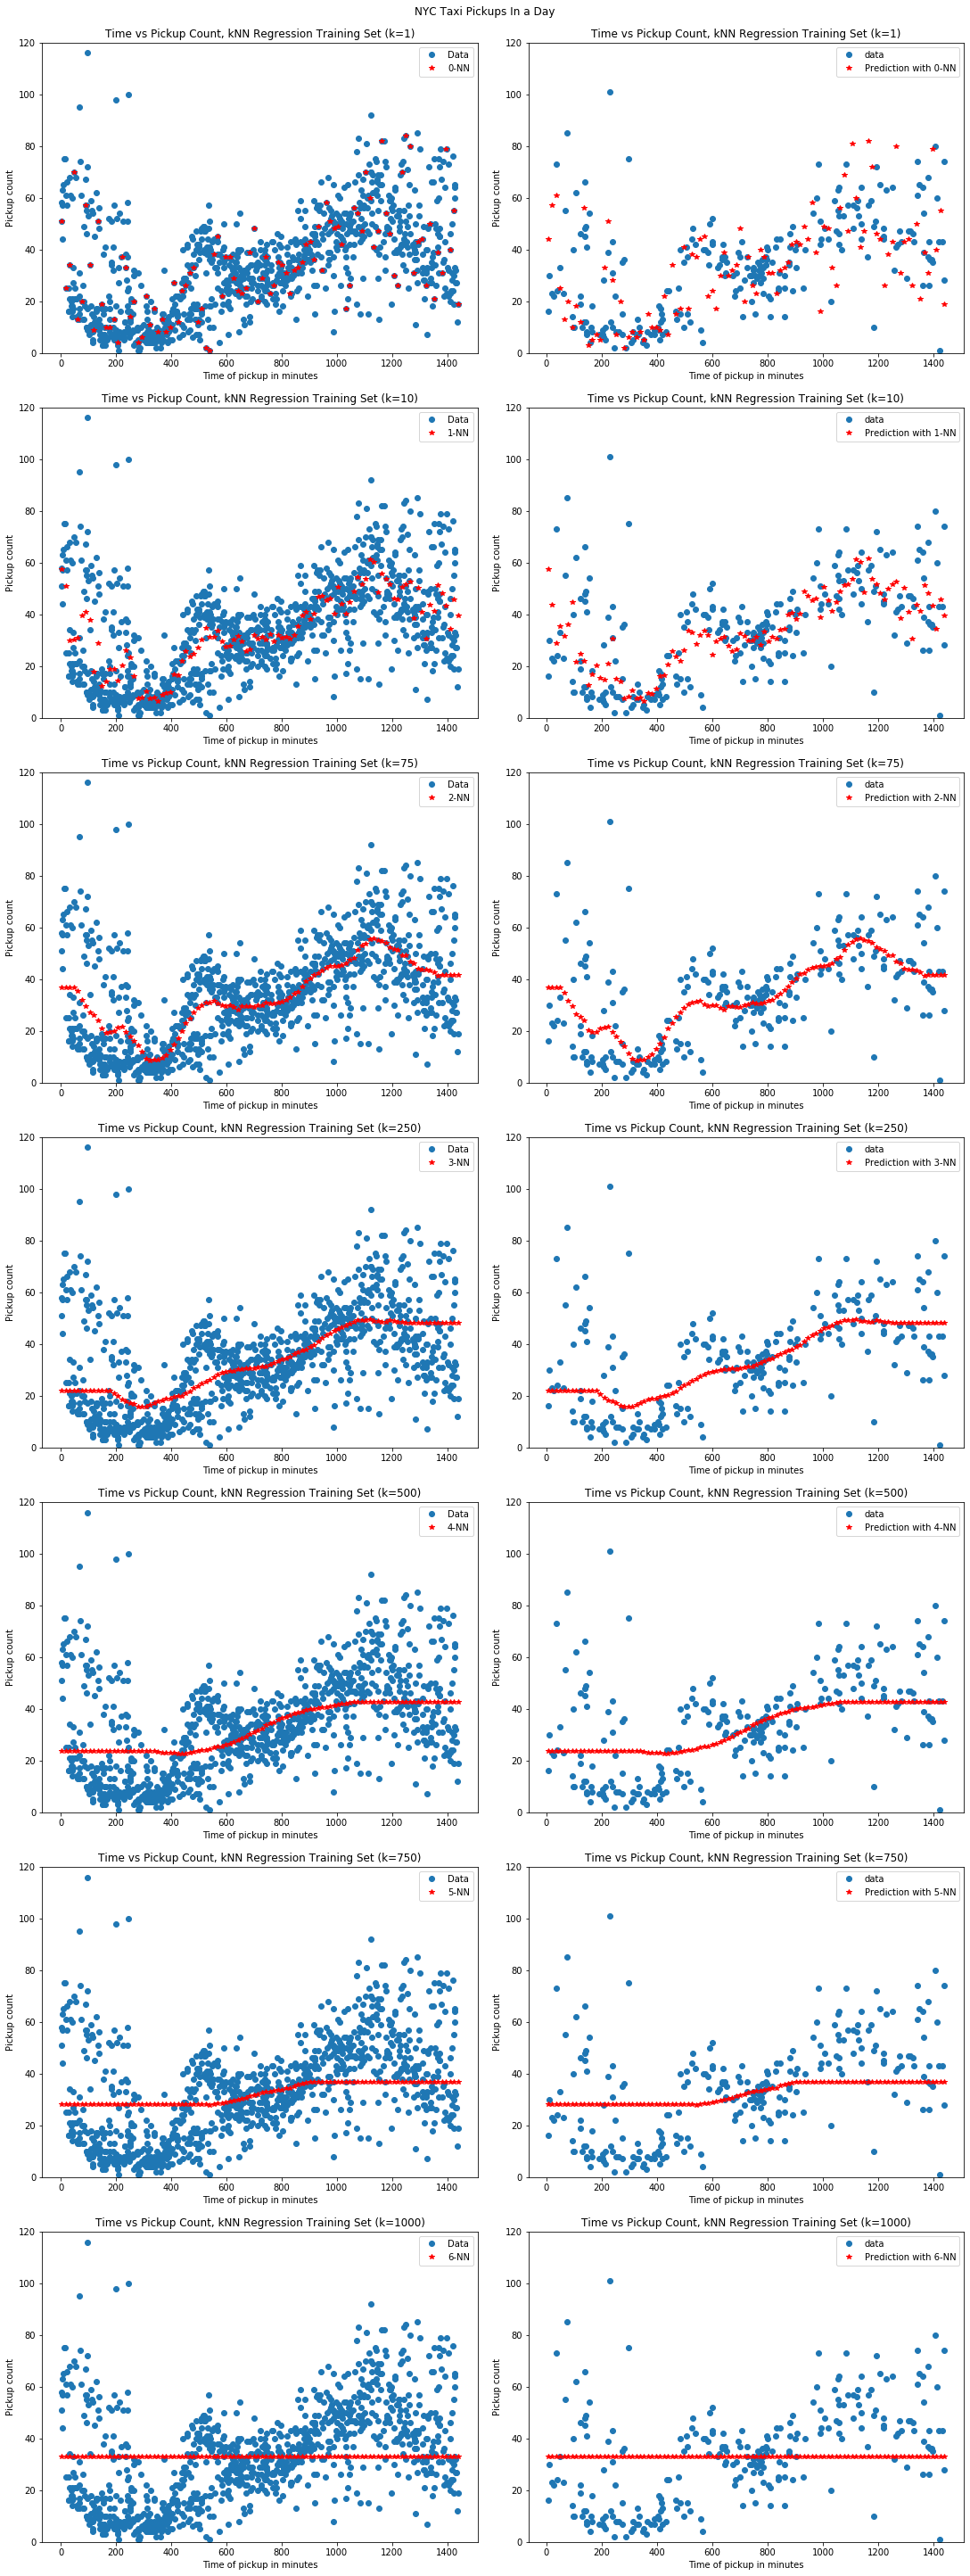

In [9]:
# For each  𝑘 , overlay a scatter plot of the actual values of PickupCount vs. TimeMin in the training set with a 
# scatter plot of predictions for PickupCount vs TimeMin. Do the same for the test set. You should have one figure 
# with 7 x 2 total subplots; for each  𝑘  the figure should have two subplots, one subplot for the training set and 
# one for the test set.

# SubPlots

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,40), constrained_layout=True)
ax = ax.ravel() 

fig.suptitle("NYC Taxi Pickups In a Day");

r2_for_later_train = {}
r2_for_later_test = {}

predictions = []


for k_unit in range(len(k_list)):
    xgrid_train = np.linspace(np.min(train_data.TimeMin), np.max(train_data.TimeMin), 100)
    xgrid_test = np.linspace(np.min(test_data.TimeMin), np.max(test_data.TimeMin), 100)
    
    for duplicate in range(2):
        
        if duplicate % 2 == 0:            
            predictions = KNNmodels[k_list[k_unit]].predict(xgrid_train.reshape(100,1)) 
            
            r2_for_later_train[k_list[k_unit]] = KNNmodels[k_list[k_unit]].predict(x_train_taxi)           
            
            ax[(k_unit * 2) + duplicate].plot(train_data.TimeMin, train_data.PickupCount, 'o', label="Data")
            ax[(k_unit * 2) + duplicate].plot(xgrid_train, predictions, '*', color ='r', label="{}-NN".format(k_unit))

        else:
            predictions = KNNmodels[k_list[k_unit]].predict(xgrid_test.reshape(100,1)) 
            
            r2_for_later_test[k_list[k_unit]] = KNNmodels[k_list[k_unit]].predict(x_test_taxi)        
            
            ax[((k_unit * 2) + duplicate)].plot(test_data.TimeMin, test_data.PickupCount, 'o', label="data")
            ax[(k_unit * 2) + duplicate].plot(xgrid_test, predictions,'*', color ='r', label="Prediction with {}-NN".format(k_unit))
            
        ax[(k_unit * 2) + duplicate].set_ylim([0,120])
        ax[(k_unit * 2) + duplicate].set_xlabel('Time of pickup in minutes')
        ax[(k_unit * 2) + duplicate].set_ylabel('Pickup count')
        ax[(k_unit * 2) + duplicate].set_title("Time vs Pickup Count, kNN Regression Training Set (k={})".format(k_list[k_unit]))            
        ax[(k_unit * 2) + duplicate].legend();

**2.3 Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**


In [10]:
# To compute the mean squared error (notice that we are now using the TEST set):
r2_test = []
r2_train = []
for k_unit in k_list: # iterate through list of k values
    for duplicate in range(2):
        if duplicate % 2 == 0:
            r2_train.append(r2_score(y_train_taxi, r2_for_later_train[k_unit]))
        else:
            r2_test.append(r2_score(y_test_taxi, r2_for_later_test[k_unit]))

pd.DataFrame({'$k$': k_unit, '$R^2$ score in training data': r2_train, '$R^2$ score in testing data': r2_test})

,$k$,$R^2$ score in training data,$R^2$ score in testing data
0,1000,0.712336,-0.418932
1,1000,0.509825,0.272068
2,1000,0.445392,0.390310
3,1000,0.355314,0.340341
4,1000,0.290327,0.270321
5,1000,0.179434,0.164909
6,1000,0.000000,-0.000384


**2.4 Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

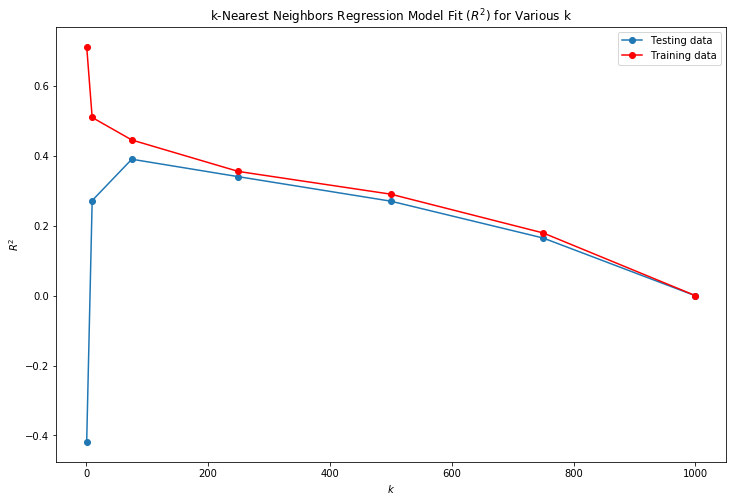

In [11]:
# # Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(k_list, r2_test,'-o', label = 'Testing data')
ax.plot(k_list, r2_train,'-or', label = 'Training data')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')
ax.set_title('k-Nearest Neighbors Regression Model Fit ($R^2$) for Various k')
ax.legend();

**2.5 Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

The k-NN regression model with k=n would predict the mean value of y for all x in the domain. This is because the k-NN model averages the y values of the k closest points in terms of x values (meaning that the x values of each point are used to determine closeness). With k=n, every point is considered a neighbor and is averaged together to produce the predicted y value.

2. What does an $R^2$ score of $0$ mean?  

An $R^2$ score of $0$ means that none of the variation in y is explained by the model. This means that the sum of the squared residuals equals the sum of the squared differences from the mean. This can occur when the model is simply the mean of the dataset (as in k-NN with k = n or greater) as well as when very poorly-fitting models are applied to data (such as a parabola fit to a scatter of points with a uniform distribution), in which cases the total sum of squared residuals and the total sum of squared differences from the mean would both be large (and possibly equivalent such that $R^2$ = 0.

3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

A negative $R^2$ means that the model fits the data worse than the mean. Specifically, the sum of the squared residuals is greater than the sum of the squared differences from the mean. A negative $R^2$ is an indicator of overfitting, meaning that the model represents the training data well but does not generalize adequately to the testing set. In cases of overfitting, a true y value in the testing set is closer to its own mean (i.e., the testing mean) than it is to its predicted value given the training set. There are some negative $R^2$ values observed in 2.3m namely the $R^2$ in testing data using k=1 (where $R^2$ = -0.418932) and k=1000 (where $R^2$ = -0.000384).

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

Yes. For the testing data, $R^2$ improves from k=1 to k of approximately 75 while for the training data it decreases from k=1 to k of approximately 75. As k increases to 1000 after approximately k=75, $R^2$ in both the training and testing sets decreases. The $R^2$ values for training and testing seem to converge from k=250 to k=1000, which indicates that the model explains variation in y similarly in the training and testing sets (minimal overfitting, despite decreasing model performance as k increases to 1000). The large difference in $R^2$ values for training and testing indicates overfitting for k less than approximately 75.

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

The best value of k is approximately 75. We chose this value because the $R^2$ value in the testing data is the highest value (0.390310) out of all $R^2$ scores generated in the testing data by the k list we considered and there is only mild overfitting (as indicated by a relatively small difference between the $R^2$ for training and testing data). The $R^2$ value in the training data is 0.445392, and the difference between the $R^2$ values for training minus testing is therefore 0.055082.

6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).** ****

The plot of the k-NN model in the testing set with k=75 in question 2.2 is the last plot as k increases before the overall pattern of the data is not represented in the predicted values in the testing set. With k=250, the predictions in the testing set are noticably converging around the mean (black stars are forming a solid, horizontal band), which supports that this k value is not allowing a model that reflects the pattern of the data. The plots of k=75 still show some sinusoidal pattern while the plots with k at one step higher (k=250) have predictions that seem to be dominated by the mean of the data ("washed out" model). It may be important not to have this type of washed out model (where predictions are close to a horizontal line) because the model may not be useful if it does not reflect some diurnal fluctuations. At k=10, however, the diurnal or sinusoidal fluctuations in the data may be too large such that predictions in the test set are less representative of the general pattern (instead they adhere to the specific pattern in the training set).

<hr>

### <div class="exercise"> <b> Question 3 [25 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4**. Report the estimates for the slope and intercept for the fitted linear model.  

**3.5**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers

**3.1 Again choose `TimeMin` as your predictor and `PickupCount` as your response variable...**

In [12]:
x_train_taxi_ac = sm.add_constant(x_train_taxi)
x_test_taxi_ac = sm.add_constant(x_test_taxi)

# Split Data into X,Y
# We used train_pickup_array and train_time_array for the training data previously; similarly, we used 
# test_pickup_array and test_time_array previously.

model = sm.OLS(y_train_taxi, x_train_taxi_ac)
OLSModel = model.fit()
print(OLSModel.params)
beta0_sm = OLSModel.params[0]
beta1_sm = OLSModel.params[1]
print(OLSModel.summary())

const    16.750601
x1        0.023335
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            PickupCount   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     320.4
Date:                Wed, 25 Sep 2019   Prob (F-statistic):           2.34e-62
Time:                        21:12:30   Log-Likelihood:                -4232.9
No. Observations:                1000   AIC:                             8470.
Df Residuals:                     998   BIC:                             8480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

//anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**3.2 Create a plot just like you did in 2.2 (but with fewer subplots)...** 

const    16.750601
x1        0.023335
dtype: float64


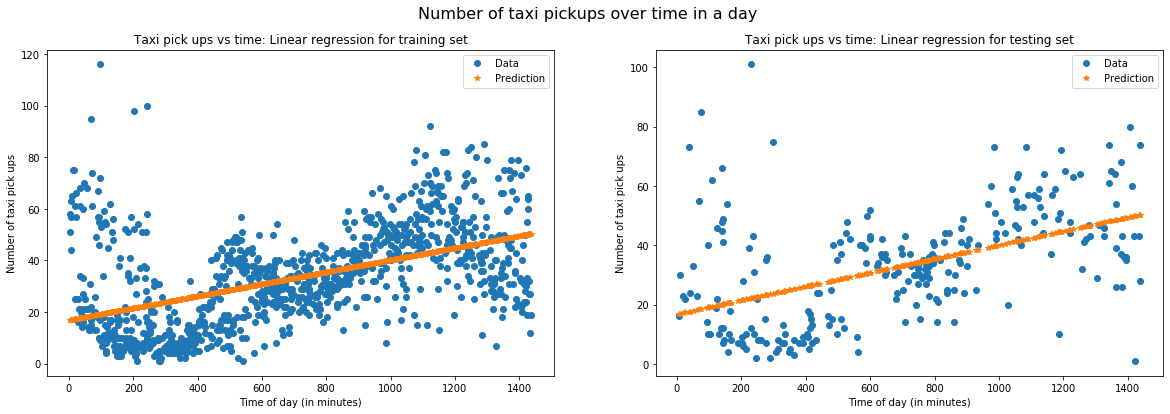

In [13]:
# Plotting our model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

axes[0].plot(x_train_taxi, y_train_taxi, 'o', label = 'Data')
sorted_time = train_data.sort_values(['TimeMin'])
prediction_taxi = OLSModel.predict(sm.add_constant(sorted_time[['TimeMin']]))
axes[0].plot(sorted_time['TimeMin'], prediction_taxi, '*', label = 'Prediction')
axes[0].set_title('Taxi pick ups vs time: Linear regression for training set')
print(OLSModel.params)

axes[1].plot(x_test_taxi, y_test_taxi, 'o', label = 'Data')
sorted_time = test_data.sort_values(['TimeMin'])
prediction_taxi = OLSModel.predict(sm.add_constant(sorted_time[['TimeMin']]))
axes[1].plot(sorted_time['TimeMin'], prediction_taxi, '*', label = 'Prediction')
axes[1].set_title('Taxi pick ups vs time: Linear regression for testing set')

for i, ax in enumerate(axes):
    ax.set_xlabel('Time of day (in minutes)')
    ax.set_ylabel('Number of taxi pick ups')
    ax.legend()
    
plt.suptitle('Number of taxi pickups over time in a day',fontsize=16);

**3.3 Report the $R^2$ score for the fitted model on both the training and test sets.**


In [14]:
# method 1: use metrics
print("Training R^2 (using metrics):", r2_score(y_train_taxi, OLSModel.predict(x_train_taxi_ac)))
print("Testing R^2 (using metrics):", r2_score(y_test_taxi, OLSModel.predict(x_test_taxi_ac)))

# method 2: compute R^2 by hand
#Find the squared error:
y_pred_train = np.array(OLSModel.predict(x_train_taxi_ac)).reshape(-1,1)
squared_error_train = (y_train_taxi - y_pred_train)**2

# #Finding the mean squared error:
error_var_train = squared_error_train.mean()
sample_var_train = ((y_train_taxi - y_train_taxi.mean())**2).mean()

y_pred_test = np.array(OLSModel.predict(x_test_taxi_ac)).reshape(-1,1)
squared_error_test = (y_pred_test - (np.array(y_test_taxi)).reshape(-1,1))**2

 #Finding the mean squared error:
error_var_test = squared_error_test.mean()

sample_var_test = ((y_test_taxi - y_test_taxi.mean())**2).mean()


print('Training R^2 (by manual calculation):', 1 - error_var_train/sample_var_train)
print('Testing R^2 (by manual cal2culation):', 1 - error_var_test/sample_var_test)

Training R^2 (using metrics): 0.24302603531893352
Testing R^2 (using metrics): 0.240661535615741
Training R^2 (by manual calculation): PickupCount    0.243026
dtype: float64
Testing R^2 (by manual cal2culation): 0.24066153561574122


**3.4 Report the estimates for the slope and intercept for the fitted linear model.**

In [15]:
# method 1: use model summary

print("The regression coefficients from the statsmodels package are: beta_0 = {0:8.6f} and beta_1 = {1:8.6f}".format(beta0_sm, beta1_sm))


# method 2: compute estimates by hand

# intercept is beta0
# slope is beta1

# based off of our understanding of the equation for linear regression
y_bar = np.mean(y_train_taxi)
x_bar = np.mean(x_train_taxi)

# reshaping pickup array training data
#train_pickup_array_reshaped = train_pickup_array.reshape(len(train_time_array),1)

# calculating numerator and denominator for beta1
numerator = np.sum((x_train_taxi - x_bar)*(y_train_taxi - y_bar))
denominator = np.sum((x_train_taxi - x_bar)**2)

# slope beta1
beta_1 = numerator/denominator

# intercept beta0
beta_0 = y_bar - beta_1*x_bar

print("By manual calculation, this is the value for the intercept (or beta_0):", beta_0[0])
print("By manual calculation, this is the value for the slope (or beta_1):", beta_1[0])

The regression coefficients from the statsmodels package are: beta_0 = 16.750601 and beta_1 = 0.023335
By manual calculation, this is the value for the intercept (or beta_0): 16.75060142744681
By manual calculation, this is the value for the slope (or beta_1): 0.02333517569239735


**3.5 Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 


In [16]:
# your code here
# Confidence Interval using Stats Model Summary
thresh = 0.05
intervals = OLSModel.conf_int(alpha=thresh)

# Renaming column names
first_col = str(thresh/2*100)+"%"
second_col = str((1-thresh/2)*100)+"%"
intervals = intervals.rename(columns={0:first_col,1:second_col})
display(intervals)

,2.5%,97.5%
const,14.675141,18.826062
x1,0.020777,0.025893


In [17]:
OLSModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     320.4
Date:                Wed, 25 Sep 2019   Prob (F-statistic):           2.34e-62
Time:                        21:12:40   Log-Likelihood:                -4232.9
No. Observations:                1000   AIC:                             8470.
Df Residuals:                     998   BIC:                             8480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7506      1.058     15.838      0.000      14.675      18.826
x1             0.0233      0.001     17.900      0.000       0.021       0.026
==============================================================================
Omnibus:                      203.688   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.910
Skew:                           1.111   Prob(JB):                    3.02e-101
Kurtosis:                       5.485   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**3.6 Discuss the results:**

**1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.**

The test $R^2$ is 0.240661535615741, which is less than the best $R^2$ found with k-NN regression (0.390310 when k=75). This makes sense because the data are not linear so the k-NN regression was able to represent the data more appropriately. It is reasonable that there is not a linear relationship between the time of day and number of pickups because there are diurnal fluctuations and the start and end points of the day should have similar numbers of pickups (because essentially at the same time of day).



**2. What does the sign of the slope of the fitted linear model convey about the data?**

The sign of the slope (positive) in the fitted linear model indicates that as the day progresses, there are more pickups. Specifically, as the x variable increases the y variable does so as well in a proportional manner (0.023 additional rides for every 1 minute later in the day).

**3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know?**

There is 95% confidence that the coefficient for the slope (beta1) is within the range 0.020777 to 0.025893. This means that if 100 linear regression models were performed each in a new sample, 95 of these models would have slope coefficients (beta1) that were contained in the range 0.020777 to 0.025893. There is 95% confidence that the coefficient for the intercept (beta0) is within the range 14.675141 to 18.826062. This means that if 100 linear regression models were performed each in a new sample, 95 of these models would have intercept coefficients (beta0) that were contained in the range 14.675141 to 18.826062. Because both of these ranges do not contain 0, there is evidence that the number of taxi pickups has a significant linear relationship with time of day. Not containing 0 in the confidence interval for beta1 indicates that we are 95% certain that the slope coefficient is positive (indicating no null relationship). Not containing 0 in the confidence interval for beta0 indicates that we are 95% certain that the intercept coefficient is positive (indicating we are 95% certain that the estimate for beta0 is not 0).


**4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.**


99% confidence intervals for the slope and intercept would be wider than 95% confidence intervals but would have the same midpoint. This is because 99% confidence intervals allow greater certaintly but this can only happen if we permit a larger range of values (assuming we are using the same sample). Because the center of the confidence interval is the mean estimate of the coefficient (i.e., beta1 or beta0 estimate), the midpoint will not change even though the interval will become wider because we define the center of the confidence interval to be the mean estimate.

**5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?**

The endpoints x of 0 and 1440 should be restricted to have the same y value predictions. This is because they represent essentially the same time of day. The only linear model that would be appropriate for this data given this restriction is where all predictions are the mean (horizontal line at the mean of y values). Other linear models fit to the data necessitate that the start and end points are different (other horizontal lines besides the mean would not fit the data better than the mean) assuming that the linear model has significant intercept and slope coefficients (with confidence intervals that do not span 0). Other models such as polynomial or kNN may be more appropriate.

<hr>

## <div class="theme"> Outliers </div>

You may recall from lectures that OLS Linear Regression can be susceptible to outliers in the data.  We're going to look at a dataset that includes some outliers and get a sense for how that affects modeling data with Linear Regression.  **Note, this is an open-ended question, there is not one correct solution (or even one correct definition of an outlier).**


### <div class="exercise"><b> Question 4 [30 pts] </b></div>




**4.1**. We've provided you with two files `outliers_train.csv` and `outliers_test.csv` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of potential outliers in the data?

**4.2**. Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.

**4.3**. You're given the knowledge ahead of time that there are 3 outliers in the training set data.  The test set data doesn't have any outliers.  You want to remove the 3 outliers in order to get the optimal intercept and slope.  In the case that you're sure of the existence and number (3) of outliers ahead of time, one potential brute force method to outlier detection might be to find the best Linear Regression model on all possible subsets of the training set data with 3 points removed.  Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?

**4.4**  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data. Place your algorithm in the function `find_outliers_simple`.  It should take the parameters `dataset_x`, `dataset_y`, and `num_outliers` representing your features, response variable values (make sure your response variable is stored as a numpy column vector), and the number of outliers to remove.  Your algorithm should select the `num_outliers` most extreme residuals from the linear regression model to predict, `dataset_y` from `dataset_x`.  The return value should be a list `outlier_indices` representing the indices of the `num_outliers` outliers in the original datasets you passed in.  Apply your function to the training data in order to identify 3 outliers.  Use `statsmodels` to create a Linear Regression model on the remaining training set data (with the 3 outliers removed), and store your model in the variable `OutlierFreeSimpleModel`.

**4.5** Create a figure with two subplots: the first is a scatterplot where the color of the points denotes the outliers from the non-outliers in the training set, and include two regression lines on this scatterplot: one fitted with the outliers included and one fitted with the outlier removed (all on the training set).  The second plot should include a scatterplot of points from the test set with the same two regression lines fitted on the training set: with and without outliers.  Visually which model fits the test set data more closely?

**4.6**. Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?

**4.7**. One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers.  In general you can't expect to know ahead of time the number of outliers in your dataset.  Propose how you would alter and/or use the algorithm you constructed in 4.4 to create a more general heuristic (i.e. one which doesn't presuppose the number of outliers) for finding outliers in your dataset.  

**Hints**:
   1. Should outliers be removed one at a time or in batches?
   2. What metric would you use and how would you use it to determine how many outliers to consider removing?

### Answers
**4.1  We've provided you with two files `outliers_train.txt` and `outliers_test.txt` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of outliers in the data?** 

,X,Y
0,-0.773019,-219.103753
1,-0.394034,-334.859357
2,0.630360,-16.232549
3,-0.350418,-179.034618
4,-1.491328,-109.710316
5,-0.119129,-250.992560
6,-1.742547,-15.976455
7,1.085502,243.835916
8,-0.318393,78.936128
9,-1.469421,-207.045450


,X,Y
count,53.000000,53.000000
mean,-0.060179,-12.356066
std,1.022698,166.899480
min,-2.110000,-334.859357
25%,-0.813775,-134.582390
50%,0.011852,14.303940
75%,0.630360,105.731108
max,1.931000,320.000000


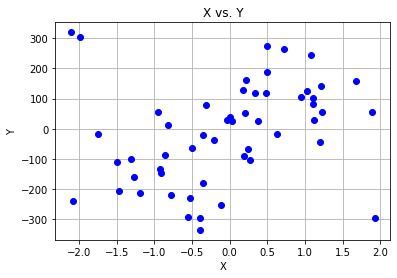

In [18]:
# reading in CSV file
outliers_train = pd.read_csv('data/outliers_train.csv', sep=",")

# EDA 1: viewing data in a table to see numerical values
display(outliers_train.head(10))
display(outliers_train.describe())

# EDA 2: plotting X and Y together as a scatter plot to see any trends
plt.figure(figsize=[6,4])
plt.plot(outliers_train['X'],outliers_train['Y'],'ob')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X vs. Y')
plt.grid(True)
plt.show()

There are 3 clear outliers. Two are in the upper left-hand corner and one is in the lower right-hand corner.

**4.2 Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.**



//anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const    -9.506264
X        47.355423
dtype: float64
0.08420240965174708


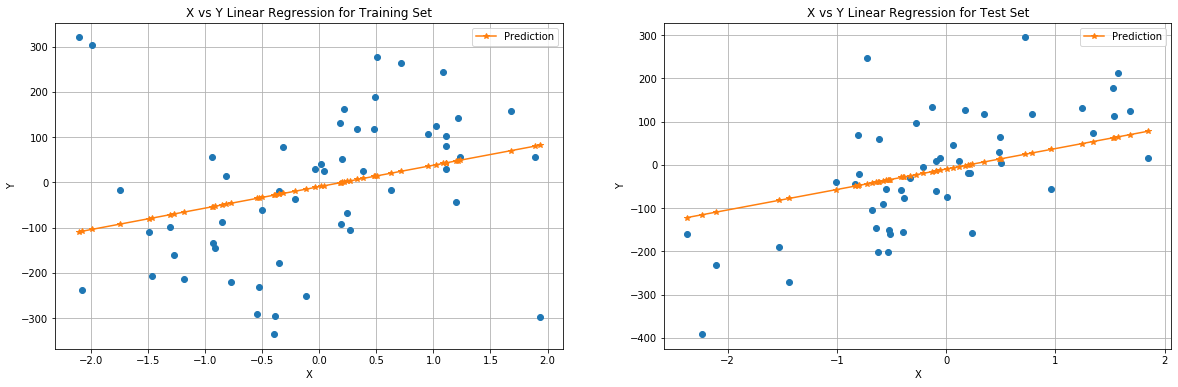

In [19]:
# reading in data as a pandas dataframe
outliers_test = pd.read_csv('data/outliers_test.csv')

# splitting data into training and testing sets manually (completed manually in statsmodel; sklearn has its own method)
x_train_out, y_train_out = outliers_train['X'], outliers_train['Y']
x_test_out, y_test_out = outliers_test['X'], outliers_test['Y']

# adding column of 1s to x train and test data (necessary step in statsmodel; automatic in sklearn)
x_train_out_ca = sm.add_constant(x_train_out)
x_test_out_ca = sm.add_constant(x_test_out)

# defining the model (using OLS as linear regression model) and verifying the result of the fit
OutlierOLSModel = sm.OLS(y_train_out, x_train_out_ca)
results_out = OutlierOLSModel.fit()
print(results_out.params)
print(results_out.rsquared)

# plotting the results of the linear regression on the training set in 2 instances: (1) on the training model and (2) on the testing model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

# training set
axes[0].plot(x_train_out, y_train_out, 'o')
axes[0].grid(True)
sorted_time_out = x_train_out.sort_values()
prediction_out = results_out.predict(sm.add_constant(sorted_time_out))
axes[0].plot(sorted_time_out, prediction_out, '*-', label = 'Prediction')
axes[0].set_title('X vs Y Linear Regression for Training Set')

# test set
axes[1].plot(x_test_out, y_test_out, 'o')
axes[1].grid(True)
sorted_time_out = x_test_out.sort_values()
prediction_out = results_out.predict(sm.add_constant(sorted_time_out))
axes[1].plot(sorted_time_out, prediction_out, '*-', label = 'Prediction')
axes[1].set_title('X vs Y Linear Regression for Test Set')

# setting up labels
for i, ax in enumerate(axes):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

**4.3 You're given the knowledge ahead of time that there are 3 outliers...Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?**
  

If we know that there are 3 outliers and we are using a brute force method, testing on every possible subset of the data with 3 points removed, we would have 50 choose 53 ways, or 23,426 ways.

**4.4  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data...**

In [20]:
def find_outliers_simple(dataset_x, dataset_y, num_outliers):

    '''
    IMPLEMENTATION:
                Select the `num_outliers` most extreme residuals from the linear regression model to predict dataset_y
                from dataset_x.
    
    PARAMETERS:
                dataset_x: Features.
    
                dataset_y: Response variable stored as a numpy column vector.
    
                num_outliers: Number of outliers to remove.
                
    OUTPUTS:  
                A list `outlier_indices` representing the indices of the `num_outliers` outliers in the original 
                datasets you passed in.

    '''
    
    # verifying dataset_y is a column vector for the rest of this function
    dataset_y = np.array(dataset_y)
    
    # adding row of 1s to the column vector x
    x_train_ca = sm.add_constant((np.array(dataset_x)).reshape(-1,1))

    # defining our model
    model_out= sm.OLS(dataset_y, x_train_ca)
    results = model_out.fit()
    
    # finding residuals
    res = []
    predicted = results.predict()
    res = abs(predicted - dataset_y)
    
    # getting outlier indices
    outlier_indices = np.argsort(res)[-num_outliers:]
    
    # printing the result with every call to the function for visual verification
    print('outlier_indices:', outlier_indices)
    return list(outlier_indices)

In [21]:
# applying to outliers dataset
out_ind = find_outliers_simple(outliers_train['X'], outliers_train['Y'], 3)

outlier_indices: [52 51 50]


52    1.931
51   -1.991
50   -2.110
Name: X, dtype: float64
52   -297.0
51    303.0
50    320.0
Name: Y, dtype: float64


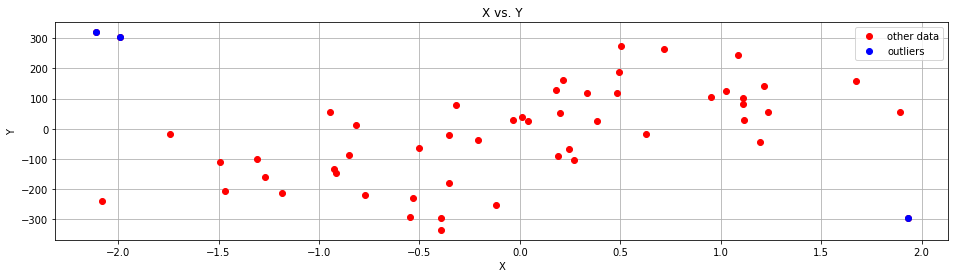

In [22]:
# quality check: verifying the indicated outliers are located as expected (upper left-hand corner and lower right-hand corner)
print(outliers_train['X'].loc[out_ind])
print(outliers_train['Y'].loc[out_ind])

# plotting the outliers and original dataset
plt.figure(figsize=[16,4])
plt.plot(outliers_train['X'],outliers_train['Y'],'ob', color = 'r', label = 'other data')
plt.plot(outliers_train['X'].loc[out_ind],outliers_train['Y'].loc[out_ind],'ob', label = 'outliers')

# labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X vs. Y')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# get outliers and calculate outlier model
# your code here
without_outliers_train = outliers_train.drop(out_ind)

x_train2, y_train2 = without_outliers_train['X'], without_outliers_train['Y']
#x_test, y_test = outliers_test['X'], outliers_test['Y']

#Add constant
x_train_ca2 = sm.add_constant(x_train2)

OutlierFreeSimpleModel = sm.OLS(y_train2, x_train_ca2)
results_out2 = OutlierFreeSimpleModel.fit()
print(results_out2.params)
print(results_out2.rsquared)

const    -17.479633
X        104.846706
dtype: float64
0.4037060455958481


**4.5 Create a figure with two subplots: the first is a scatterplot where the color of the points...**


const    -17.479633
X        104.846706
dtype: float64
0.4037060455958481
const    -9.506264
X        47.355423
dtype: float64
0.08420240965174708
const    -17.479633
X        104.846706
dtype: float64
0.4037060455958481
const    -9.506264
X        47.355423
dtype: float64
0.08420240965174708


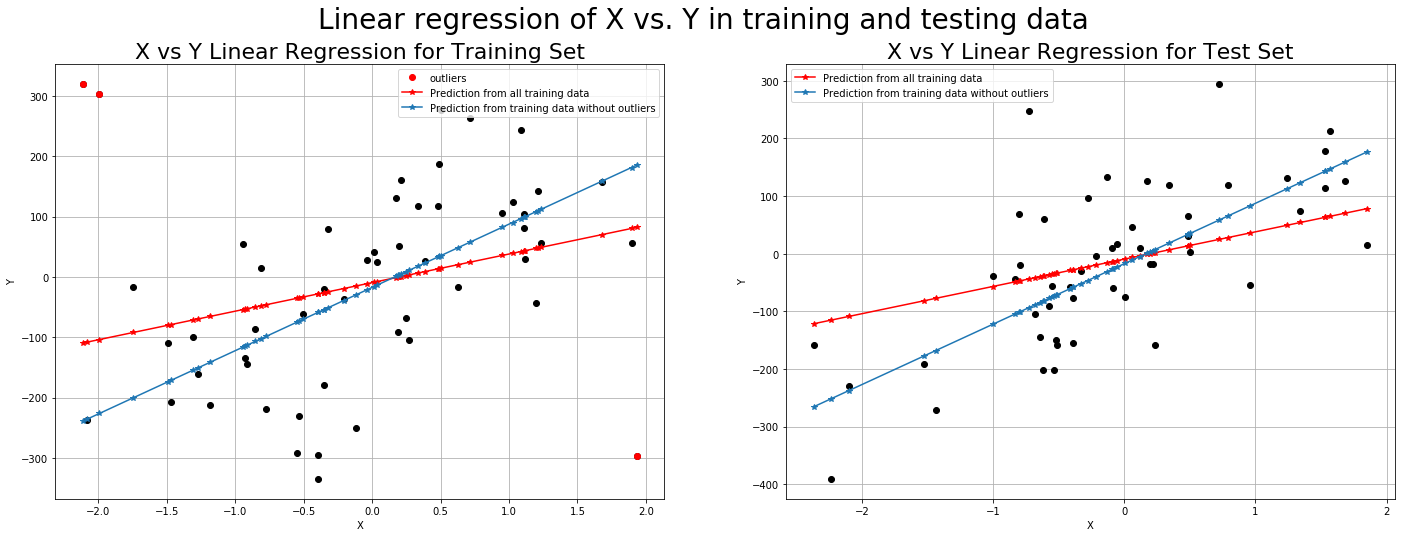

In [23]:
# plotting our model
fig, axes = plt.subplots(1,2,figsize=(24,8))
axes = axes.ravel()

# plotting the entire training dataset (outliers in red)
axes[0].plot(x_train_out, y_train_out, 'o', color='k')
axes[0].plot(outliers_train['X'].loc[out_ind],outliers_train['Y'].loc[out_ind],'o', color='r', label = 'outliers')

# finding and plotting the linear regression model in 2 ways: predicting with and without outliers
sorted_time_out2 = x_train_out.sort_values()
prediction_out2 = results_out.predict(sm.add_constant(sorted_time_out2))
axes[0].plot(sorted_time_out2, prediction_out2, '*-', color='r', label = 'Prediction from all training data')
prediction_out2 = results_out2.predict(sm.add_constant(sorted_time_out2))
axes[0].plot(sorted_time_out2, prediction_out2, '*-', label = 'Prediction from training data without outliers')
axes[0].set_title('X vs Y Linear Regression for Training Set',fontsize=22)
axes[0].grid(True)

# quality check: printing parameters and r2 values
print(results_out2.params)
print(results_out2.rsquared)
print(results_out.params)
print(results_out.rsquared)

# plotting the entire testing dataset
axes[1].plot(x_test_out, y_test_out, 'o', color='k')

# finding and plotting the linear regression model in 2 ways: predicting with and without outliers
sorted_time_out2 = x_test_out.sort_values()
prediction_out2 = results_out.predict(sm.add_constant(sorted_time_out2))
axes[1].plot(sorted_time_out2, prediction_out2, '*-', color='r', label = 'Prediction from all training data')
prediction_out2 = results_out2.predict(sm.add_constant(sorted_time_out2))
axes[1].plot(sorted_time_out2, prediction_out2, '*-', label = 'Prediction from training data without outliers')
axes[1].set_title('X vs Y Linear Regression for Test Set',fontsize=22)
axes[1].grid(True)

# quality check: printing parameters and r2 values
print(results_out2.params)
print(results_out2.rsquared)
print(results_out.params)
print(results_out.rsquared)

# labels
for i, ax in enumerate(axes):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
plt.suptitle('Linear regression of X vs. Y in training and testing data',fontsize=28);


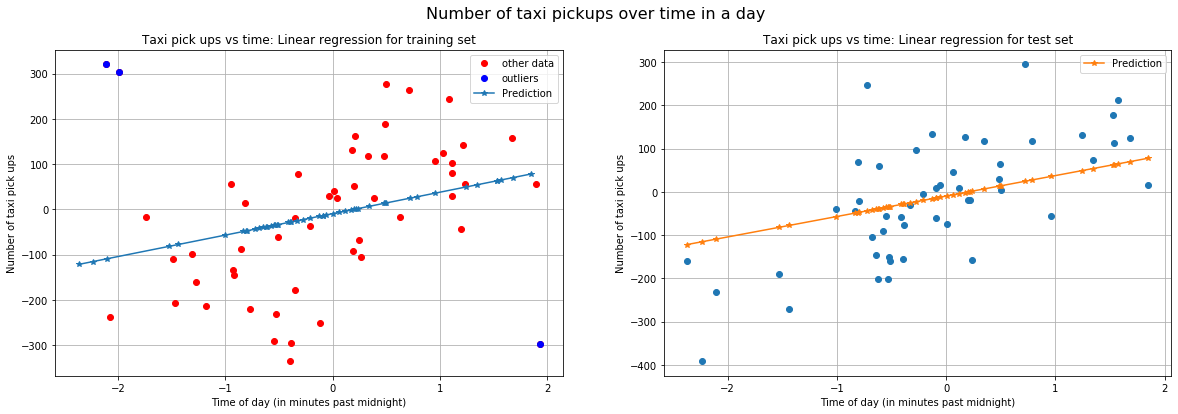

In [24]:
# Plotting our model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

# plotting the entire dataset (with outliers in blue)
axes[0].plot(outliers_train['X'],outliers_train['Y'],'ob', color = 'r', label = 'other data')
axes[0].plot(outliers_train['X'].loc[out_ind],outliers_train['Y'].loc[out_ind],'ob', label = 'outliers')

# plotting and defining the linear regression model
prediction_lr = results_out.predict(sm.add_constant(sorted_time_out2))
axes[0].plot(sorted_time_out2, prediction_lr, '*-', label = 'Prediction')
axes[0].set_title('Taxi pick ups vs time: Linear regression for training set')

# plotting the entire data set (sorted by X)
axes[1].plot(x_test_out, y_test_out, 'o')
sorted_time_test = outliers_test.sort_values(['X'])['X']
prediction_lr_test = results_out.predict(sm.add_constant(sorted_time_test))

#plotting and defining the linear regression model
axes[1].plot(sorted_time_test, prediction_lr_test, '*-', label = 'Prediction')
axes[1].set_title('Taxi pick ups vs time: Linear regression for test set')

# labels
for i, ax in enumerate(axes):
    ax.set_xlabel('Time of day (in minutes past midnight)')
    ax.set_ylabel('Number of taxi pick ups')
    ax.legend()
axes[0].grid(True)
axes[1].grid(True)
plt.suptitle('Number of taxi pickups over time in a day',fontsize=16);

By visual inspection, the linear regression made on the data sets **without outliers** creates the most fit model for linear regression. 

**4.6 Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?**


In [25]:
# WITH OUTLIERS INCLUDED

# Method 1: Step-by-step Computation
# calculating the squared error
y_pred_train = results_out.predict(x_train_out_ca)
squared_error_train = (y_pred_train - y_train_out)**2

# calculating the mean squared error:
error_var_train = squared_error_train.mean()
sample_var_train = ((y_train_out - y_train_out.mean())**2).mean()
y_pred_test = results_out.predict(x_test_out_ca)
squared_error_test = (y_pred_test - y_test_out)**2
error_var_test = squared_error_test.mean()
sample_var_test = ((y_test_out - y_test_out.mean())**2).mean()

print('Testing R^2 (by manual computation):',1 - error_var_test/sample_var_test)


# Method 2: Metrics, Performance Evaluation and Helpful Functions
from sklearn import metrics

# MSE (with test set)
print("Testing R^2 (using metrics):", metrics.r2_score(y_test_out, results_out.predict(x_test_out_ca)))

Testing R^2 (by manual computation): 0.34085656043405654
Testing R^2 (using metrics): 0.34085656043405654


In [26]:
# WITHOUT OUTLIERS

# calculating the squared error
y_pred_train = results_out2.predict(x_train_out_ca)
#print('Training R^2: ', results.rsquared)
squared_error_train = (y_pred_train - y_train_out)**2

# calculating the mean squared error:
error_var_train = squared_error_train.mean()
sample_var_train = ((y_train_out - y_train_out.mean())**2).mean()
y_pred_test = results_out2.predict(x_test_out_ca)
squared_error_test = (y_pred_test - y_test_out)**2
error_var_test = squared_error_test.mean()
sample_var_test = ((y_test_out - y_test_out.mean())**2).mean()

print('Testing R^2 (by manual computation):', 1 - error_var_test/sample_var_test)

Testing R^2 (by manual computation): 0.4529566870167582


**4.7 One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers...**

In order to find the number of outliers in the dataset, it would be possible to use a similar framework as the function generated in question 4.4 but instead to successively remove points with the largest residuals given a linear model. Specifically, we would start by fitting a linear model to all data and then calculating the residuals for all observations. We would document the baseline $R^2$ value. We would then remove the observation with the highest residual. We would then fit a new linear model over the data exluding that one outlier. We would calculate the new $R^2$ value and compute the change in the $R^2$ value. We would then use this new linear model to calculate new residuals and then remove the observation with the highest residual given the new model. We would calculate the difference in the $R^2$ value after removing the second observation compared to after removing only the first observation. We would continue to drop the observation with the highest residual for each new linear model fit until we observed a change in the rate of change of the $R^2$ value (essentially we would look for when removing points does not significantly improve the $R^2$ anymore). We would refit linear models after dropping outliers one at a time as opposed to in batches as executed in question 4.4 because we are aware that removing one point ("outlier A") and then refitting a model to the revised dataset may affect the residuals of all other points such that what may be considered an outlier ("outlier B") with respect to the original linear model with full data would not be an outlier after a certain point ("outlier A") was removed. This would allow us to drop the fewest outliers and maintain a high $R^2$. Because $R^2$ is a normalized version of the MSE (assessing the proportion of sum of squared residuals relative to the sum of squared differences from the mean), $R^2$ is a sound metric to assess model performance using this greedy approach (meaning the worst outlier is dropped each time) to finding outliers because the sample is changing for each iteration of the algorithm.